In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import copy
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from tqdm.autonotebook import tqdm
from functools import partial


Model

In [6]:
def conv3x3x3(in_planes, out_planes, stride=1):
    """
    3x3x3 convolution with padding.

    Args:
        in_planes (int): Number of input channels.
        out_planes (int): Number of output channels.
        stride (int): Stride of the convolution.

    Returns:
        nn.Conv3d: Convolutional layer.
    """
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)

def downsample_basic_block(x, planes, stride):
    """
    Downsample the input tensor using average pooling and zero-padding.

    Args:
        x (torch.Tensor): Input tensor.
        planes (int): Number of output channels.
        stride (int): Stride of the pooling.

    Returns:
        torch.Tensor: Downsampled tensor.
    """
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()
    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out

class Bottleneck(nn.Module):
    """
    Bottleneck block for ResNet.
    """
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, head_conv=1):
        """
        Initializes the Bottleneck block.

        Args:
            inplanes (int): Number of input channels.
            planes (int): Number of output channels.
            stride (int): Stride of the convolution.
            downsample (nn.Module, optional): Downsampling layer. Defaults to None.
            head_conv (int, optional): Type of head convolution. Defaults to 1.
        """
        super(Bottleneck, self).__init__()
        if head_conv == 1:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm3d(planes)
        elif head_conv == 3:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), bias=False, padding=(1, 0, 0))
            self.bn1 = nn.BatchNorm3d(planes)
        else:
            raise ValueError("Unsupported head_conv!")
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=(1, 3, 3), stride=(1, stride, stride), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """
        Forward pass of the Bottleneck block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

def get_fine_tuning_parameters(model, ft_begin_index):
    """
    Get the parameters for fine-tuning.

    Args:
        model (nn.Module): Model to fine-tune.
        ft_begin_index (int): Index of the first layer to fine-tune.

    Returns:
        list: List of parameters.
    """
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters

class SlowFast(nn.Module):
    """
    SlowFast network for video recognition.
    """
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], class_num=27, shortcut_type='B', dropout=0.5,
                 alpha=8, beta=0.125):
        """
        Initializes the SlowFast network.

        Args:
            block (nn.Module, optional): Bottleneck block. Defaults to Bottleneck.
            layers (list, optional): Number of layers in each block. Defaults to [3, 4, 6, 3].
            class_num (int, optional): Number of classes. Defaults to 27.
            shortcut_type (str, optional): Type of shortcut connection. Defaults to 'B'.
            dropout (float, optional): Dropout rate. Defaults to 0.5.
            alpha (int, optional): Temporal stride for slow path. Defaults to 8.
            beta (float, optional): Channel ratio between fast and slow path. Defaults to 0.125.
        """
        super(SlowFast, self).__init__()
        self.alpha = alpha
        self.beta = beta

        self.fast_inplanes = int(64 * beta)
        fast_inplanes = self.fast_inplanes
        self.fast_conv1 = nn.Conv3d(3, fast_inplanes, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3),
                                    bias=False)
        self.fast_bn1 = nn.BatchNorm3d(8)
        self.fast_relu = nn.ReLU(inplace=True)
        self.fast_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.fast_res1 = self._make_layer_fast(block, 8, layers[0], shortcut_type, head_conv=3)
        self.fast_res2 = self._make_layer_fast(
            block, 16, layers[1], shortcut_type, stride=2, head_conv=3)
        self.fast_res3 = self._make_layer_fast(
            block, 32, layers[2], shortcut_type, stride=2, head_conv=3)
        self.fast_res4 = self._make_layer_fast(
            block, 64, layers[3], shortcut_type, stride=2, head_conv=3)

        self.slow_inplanes = 64
        slow_inplanes = self.slow_inplanes
        self.slow_conv1 = nn.Conv3d(3, slow_inplanes, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3),
                                    bias=False)
        self.slow_bn1 = nn.BatchNorm3d(64)
        self.slow_relu = nn.ReLU(inplace=True)
        self.slow_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.slow_res1 = self._make_layer_slow(block, 64, layers[0], shortcut_type, head_conv=1)
        self.slow_res2 = self._make_layer_slow(
            block, 128, layers[1], shortcut_type, stride=2, head_conv=1)
        self.slow_res3 = self._make_layer_slow(
            block, 256, layers[2], shortcut_type, stride=2, head_conv=1)
        self.slow_res4 = self._make_layer_slow(
            block, 512, layers[3], shortcut_type, stride=2, head_conv=1)

        self.Tconv1 = nn.Conv3d(8, 16, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv2 = nn.Conv3d(32, 64, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv3 = nn.Conv3d(64, 128, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv4 = nn.Conv3d(128, 256, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)

        self.dp = nn.Dropout(dropout)
        self.fc = nn.Linear(self.fast_inplanes + self.slow_inplanes, class_num)

    def forward(self, input):
        """
        Forward pass of the SlowFast network.

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        fast, Tc = self.FastPath(input[:, :, ::2, :, :])
        slow = self.SlowPath(input[:, :, ::16, :, :], Tc)
        x = torch.cat([slow, fast], dim=1)
        x = self.dp(x)
        x = self.fc(x)
        return x

    def SlowPath(self, input, Tc):
        """
        Forward pass of the slow path.

        Args:
            input (torch.Tensor): Input tensor.
            Tc (list): List of temporal convolutional features from the fast path.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.slow_conv1(input)
        x = self.slow_bn1(x)
        x = self.slow_relu(x)
        x = self.slow_maxpool(x)
        x = torch.cat([x, Tc[0]], dim=1)
        x = self.slow_res1(x)
        x = torch.cat([x, Tc[1]], dim=1)
        x = self.slow_res2(x)
        x = torch.cat([x, Tc[2]], dim=1)
        x = self.slow_res3(x)
        x = torch.cat([x, Tc[3]], dim=1)
        x = self.slow_res4(x)
        x = nn.AdaptiveAvgPool3d(1)(x)
        x = x.view(-1, x.size(1))
        return x

    def FastPath(self, input):
        """
        Forward pass of the fast path.

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            tuple: Output tensor and list of temporal convolutional features.
        """
        x = self.fast_conv1(input)
        x = self.fast_bn1(x)
        x = self.fast_relu(x)
        x = self.fast_maxpool(x)
        Tc1 = self.Tconv1(x)
        x = self.fast_res1(x)
        Tc2 = self.Tconv2(x)
        x = self.fast_res2(x)
        Tc3 = self.Tconv3(x)
        x = self.fast_res3(x)
        Tc4 = self.Tconv4(x)
        x = self.fast_res4(x)
        x = nn.AdaptiveAvgPool3d(1)(x)
        x = x.view(-1, x.size(1))
        return x, [Tc1, Tc2, Tc3, Tc4]

    def _make_layer_fast(self, block, planes, blocks, shortcut_type, stride=1, head_conv=1):
        """
        Make a fast layer.

        Args:
            block (nn.Module): Bottleneck block.
            planes (int): Number of output channels.
            blocks (int): Number of blocks in the layer.
            shortcut_type (str): Type of shortcut connection.
            stride (int, optional): Stride of the convolution. Defaults to 1.
            head_conv (int, optional): Type of head convolution. Defaults to 1.

        Returns:
            nn.Sequential: Sequential layer.
        """
        downsample = None
        if stride != 1 or self.fast_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.fast_inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=(1, stride, stride),
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.fast_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.fast_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.fast_inplanes, planes, head_conv=head_conv))
        return nn.Sequential(*layers)

    def _make_layer_slow(self, block, planes, blocks, shortcut_type, stride=1, head_conv=1):
        """
        Make a slow layer.

        Args:
            block (nn.Module): Bottleneck block.
            planes (int): Number of output channels.
            blocks (int): Number of blocks in the layer.
            shortcut_type (str): Type of shortcut connection.
            stride (int, optional): Stride of the convolution. Defaults to 1.
            head_conv (int, optional): Type of head convolution. Defaults to 1.

        Returns:
            nn.Sequential: Sequential layer.
        """
        downsample = None
        if stride != 1 or self.slow_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.slow_inplanes + self.slow_inplanes // self.alpha * 2,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=(1, stride, stride),
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.slow_inplanes + self.slow_inplanes // self.alpha * 2, planes, stride, downsample,
                            head_conv=head_conv))
        self.slow_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.slow_inplanes, planes, head_conv=head_conv))

        return nn.Sequential(*layers)

def resnet50(**kwargs):
    """
    Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

def resnet101(**kwargs):
    """
    Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model

def resnet152(**kwargs):
    """
    Constructs a ResNet-152 model.
    """
    model = SlowFast(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

def resnet200(**kwargs):
    """
    Constructs a ResNet-200 model.
    """
    model = SlowFast(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model


Clr

In [ ]:
class OneCycle(object):
    """Implements the 1cycle learning rate/momentum scheduler.
    
    Cycles LR between max_lr/div and max_lr, and momentum between high/low values.
    """

    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt=10, div=10):
        """
        Args:
            nb: Total number of iterations
            max_lr: Maximum learning rate
            momentum_vals: Tuple of (high_momentum, low_momentum)
            prcnt: Percentage of iterations for annealing (default: 10)
            div: Division factor for minimum LR (default: 10)
        """
        self.nb = nb
        self.div = div
        self.step_len = int(self.nb * (1 - prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []

    def calc(self):
        """Returns current (learning_rate, momentum) pair."""
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)

    def calc_lr(self):
        """Calculates current learning rate based on iteration progress."""
        if self.iteration == self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * (1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1 - (self.iteration - self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else:
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr

    def calc_mom(self):
        """Calculates current momentum based on iteration progress."""
        if self.iteration == self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else:
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom


def update_lr(optimizer, lr):
    """Updates learning rate for all parameter groups in optimizer."""
    for g in optimizer.param_groups:
        g['lr'] = lr


def update_mom(optimizer, mom):
    """Updates momentum for all parameter groups in optimizer."""
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [8]:
data_path = '/root/tatneft/datasets/violations_dataset/cuts1_labels.txt'

# Read class labels from file and store them in a list
with open(data_path, 'r') as file:
    classes = [line.strip() for line in file.readlines()]

print(classes)

# Create a decoder dictionary that maps class labels to their index
decoder = {classes[i]: i for i in range(len(classes))}

# Create an encoder dictionary that maps indices to class labels
encoder = {i: classes[i] for i in range(len(classes))}

print("Decoder:", decoder)
print("Encoder:", encoder)

# List to store video paths and class labels
id_list = []

# Path to the annotation file containing video paths and corresponding class labels
annotations_path = '/root/tatneft/datasets/violations_dataset/cuts1_train.txt'

# Read the annotation file and store video paths with class labels in id_list
with open(annotations_path, 'r') as file:
    for line in file:
        video_path, class_label = line.strip().split()
        id_list.append((video_path, int(class_label)))

# Print the total number of entries and the first five samples
print(len(id_list))
print(id_list[:5])

['gas_analyzer', 'syringing', 'inspection', 'measure', 'pipe_work', 'HRW_work', 'pipe_up', 'pipe_down', 'cleaning', 'open_mouth', 'gaskets', 'spider_landing', 'unscrewing PCP', 'remove_PCP', 'unscrewing_PCP', 'crane_lowering', 'crane_lifting', 'PCP_roll', 'cross_rotation']
Decoder: {'gas_analyzer': 0, 'syringing': 1, 'inspection': 2, 'measure': 3, 'pipe_work': 4, 'HRW_work': 5, 'pipe_up': 6, 'pipe_down': 7, 'cleaning': 8, 'open_mouth': 9, 'gaskets': 10, 'spider_landing': 11, 'unscrewing PCP': 12, 'remove_PCP': 13, 'unscrewing_PCP': 14, 'crane_lowering': 15, 'crane_lifting': 16, 'PCP_roll': 17, 'cross_rotation': 18}
Encoder: {0: 'gas_analyzer', 1: 'syringing', 2: 'inspection', 3: 'measure', 4: 'pipe_work', 5: 'HRW_work', 6: 'pipe_up', 7: 'pipe_down', 8: 'cleaning', 9: 'open_mouth', 10: 'gaskets', 11: 'spider_landing', 12: 'unscrewing PCP', 13: 'remove_PCP', 14: 'unscrewing_PCP', 15: 'crane_lowering', 16: 'crane_lifting', 17: 'PCP_roll', 18: 'cross_rotation'}


In [11]:
class video_dataset(Dataset):
    """
    PyTorch Dataset for loading video sequences with fixed frame length.
    """
    def __init__(self, frame_list, sequence_length=16, transform=None, im_size=256):
        self.frame_list = frame_list
        self.transform = transform
        self.sequence_length = sequence_length
        self.im_size = im_size

    def __len__(self):
        return len(self.frame_list)

    def __getitem__(self, idx):
        path, label = self.frame_list[idx]
        path = '/root/tatneft/datasets/violations_dataset/cuts1/' + path

        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            raise ValueError(f"Failed to open video file: {path}")

        frames = []
        while len(frames) < self.sequence_length:
            ret, frame = cap.read()
            if not ret:
                break

            if self.transform:
                frame = self.transform(frame)

            frames.append(frame)

        cap.release()

        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))

        seq_image = torch.stack(frames)  # Shape: (sequence_length, channels, height, width)
        seq_image = seq_image.permute(1, 0, 2, 3)  # Shape: (channels, sequence_length, height, width)

        return seq_image, label

In [12]:
# Image parameters
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]

# Define transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load training data
train_data = video_dataset(id, sequence_length=10, transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=8, num_workers=1, shuffle=True)

# Load validation data
val_path = '/root/tatneft/datasets/violations_dataset/cuts1_val.txt'
val_id = []
with open(val_path, 'r') as file:
    for line in file:
        video_path, class_label = line.strip().split()
        val_id.append((video_path, int(class_label)))

val_data = video_dataset(val_id, sequence_length=10, transform=train_transforms)
val_loader = DataLoader(val_data, batch_size=8, num_workers=1, shuffle=False)

# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

# Print available keys
print(dataloaders.keys())


dict_keys(['train', 'val'])


In [13]:
model = resnet200(class_num=19)

In [14]:
"""Learnig parameters"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'

cls_criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)

num_epochs = 20

onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

In [12]:
# Create directory for saving model weights
os.makedirs('/root/akhsup/weights', exist_ok=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Initialize training variables
iteration = 0
train_losses, val_losses = [], []
precisions, recalls, f1_scores = [], [], []
train_loss, val_loss = 0.0, 0.0
best_f1 = 0.0

# Move model to the appropriate device
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1} ---")
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        epoch_loss = 0.0
        all_labels, all_preds = [], []

        for batch_i, (X, y) in tqdm(enumerate(dataloaders[phase])):
            image_sequences = X.to(device)
            labels = y.to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(image_sequences)
                loss = cls_criterion(predictions, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            epoch_loss += loss.item() * image_sequences.size(0)
            _, preds = torch.max(predictions, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update learning rate and momentum for training phase
            if phase == 'train':
                lr, mom = onecyc.calc()
                update_lr(optimizer, lr)
                update_mom(optimizer, mom)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Compute average loss and metrics
        epoch_loss /= len(dataloaders[phase].dataset)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_loss = epoch_loss
        else:
            val_losses.append(epoch_loss)
            val_loss = epoch_loss
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            
            # Save best model based on F1-score
            if f1 > best_f1:
                best_f1 = f1
                best_epoch = epoch + 1
                torch.save(model.state_dict(), f'/root/akhsup/weights/best_model_f1_{best_epoch}.pth')
    
    print(f"Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

print(f"Best F1-score: {best_f1:.4f} in epoch {best_epoch}")



--- Epoch 1 ---


48it [01:43,  2.15s/it]
10it [00:20,  2.05s/it]


Train_loss: 2.6855, Val_loss: 65.3912, Precision: 0.1157, Recall: 0.2785, F1: 0.1612

--- Epoch 2 ---


48it [01:37,  2.04s/it]
10it [00:19,  2.00s/it]


Train_loss: 2.6410, Val_loss: 3.8591, Precision: 0.1792, Recall: 0.2278, F1: 0.1901

--- Epoch 3 ---


48it [01:36,  2.02s/it]
10it [00:19,  1.99s/it]


Train_loss: 2.6023, Val_loss: 2.4220, Precision: 0.1760, Recall: 0.3038, F1: 0.2116

--- Epoch 4 ---


48it [01:39,  2.07s/it]
10it [00:20,  2.00s/it]


Train_loss: 2.6003, Val_loss: 2.1498, Precision: 0.2019, Recall: 0.2911, F1: 0.2326

--- Epoch 5 ---


48it [01:36,  2.02s/it]
10it [00:19,  1.98s/it]


Train_loss: 2.5035, Val_loss: 2.0964, Precision: 0.2764, Recall: 0.4557, F1: 0.3300

--- Epoch 6 ---


48it [01:39,  2.07s/it]
10it [00:19,  1.99s/it]

Train_loss: 2.4698, Val_loss: 2.0740, Precision: 0.2466, Recall: 0.3418, F1: 0.2723

--- Epoch 7 ---



48it [01:54,  2.38s/it]
10it [00:20,  2.05s/it]

Train_loss: 2.4280, Val_loss: 1.9892, Precision: 0.2316, Recall: 0.3038, F1: 0.2426

--- Epoch 8 ---



48it [01:37,  2.03s/it]
10it [00:20,  2.02s/it]

Train_loss: 2.4173, Val_loss: 3.6172, Precision: 0.1321, Recall: 0.2785, F1: 0.1739

--- Epoch 9 ---



48it [01:39,  2.08s/it]
10it [00:20,  2.01s/it]

Train_loss: 2.4288, Val_loss: 2.0961, Precision: 0.2880, Recall: 0.4430, F1: 0.3292

--- Epoch 10 ---



48it [01:37,  2.03s/it]
10it [00:20,  2.02s/it]

Train_loss: 2.1298, Val_loss: 1.9297, Precision: 0.3571, Recall: 0.3165, F1: 0.2943

--- Epoch 11 ---



48it [01:36,  2.02s/it]
10it [00:19,  2.00s/it]


Train_loss: 2.1147, Val_loss: 1.7433, Precision: 0.3899, Recall: 0.4304, F1: 0.3913

--- Epoch 12 ---


48it [01:38,  2.05s/it]
10it [00:20,  2.06s/it]

Train_loss: 2.0902, Val_loss: 1.7476, Precision: 0.4574, Recall: 0.3544, F1: 0.3323

--- Epoch 13 ---



48it [01:37,  2.03s/it]
10it [00:19,  1.99s/it]

Train_loss: 2.0066, Val_loss: 1.4516, Precision: 0.3391, Recall: 0.4177, F1: 0.3637

--- Epoch 14 ---



48it [01:40,  2.09s/it]
10it [00:20,  2.03s/it]

Train_loss: 1.7505, Val_loss: 1.6653, Precision: 0.3179, Recall: 0.3671, F1: 0.3296

--- Epoch 15 ---



48it [01:38,  2.05s/it]
10it [00:20,  2.02s/it]


Train_loss: 1.8837, Val_loss: 1.4327, Precision: 0.4706, Recall: 0.5443, F1: 0.4846

--- Epoch 16 ---


48it [01:38,  2.05s/it]
10it [00:20,  2.03s/it]

Train_loss: 1.7939, Val_loss: 1.5954, Precision: 0.3680, Recall: 0.4177, F1: 0.3639

--- Epoch 17 ---



48it [01:37,  2.02s/it]
10it [00:20,  2.00s/it]

Train_loss: 1.7613, Val_loss: 1.1609, Precision: 0.3662, Recall: 0.5949, F1: 0.4510

--- Epoch 18 ---



48it [01:37,  2.03s/it]
10it [00:19,  2.00s/it]

Train_loss: 1.4146, Val_loss: 1.3356, Precision: 0.4345, Recall: 0.4557, F1: 0.3942

--- Epoch 19 ---



48it [01:34,  1.97s/it]
10it [00:19,  1.97s/it]


Train_loss: 1.5187, Val_loss: 1.0230, Precision: 0.5884, Recall: 0.6962, F1: 0.6200

--- Epoch 20 ---


48it [01:35,  2.00s/it]
10it [00:19,  1.96s/it]

Train_loss: 1.3856, Val_loss: 1.0356, Precision: 0.5970, Recall: 0.6709, F1: 0.5832
Best F1-score: 0.6200 in epoch 20


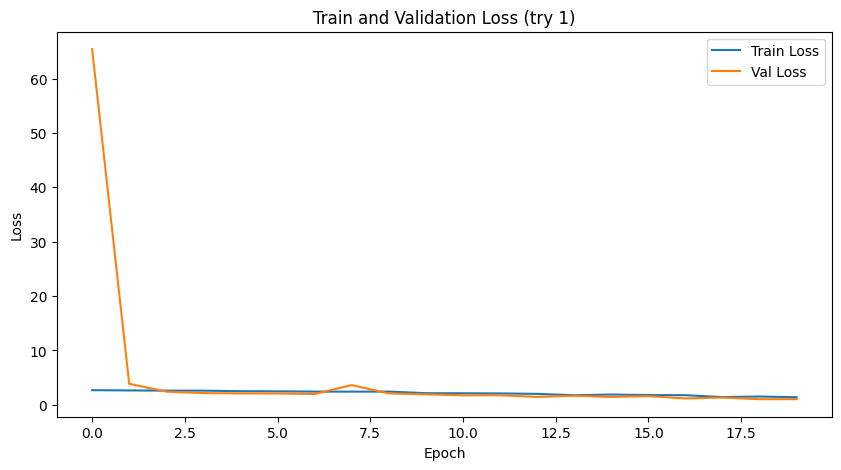

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (try 1)')
plt.legend()
plt.savefig('/root/akhsup/weights/loss_plot.png')
plt.show()

In [9]:
def load_model(model_path, num_classes=19):
    """
    Load the pretrained model from the specified path.
    """
    model = resnet200(class_num=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def preprocess_video(video_path, sequence_length=10, im_size=128):
    """
    Preprocess the video into a tensor that can be fed into the model.
    """
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4889, 0.4887, 0.4891], std=[0.2074, 0.2074, 0.2074])
    ])

    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame) 
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        raise ValueError(f"Ошибка: Видео '{video_path}' не содержит кадров или файл повреждён.")

    # Pad the frames to ensure the sequence length is met
    while len(frames) < sequence_length:
        frames.append(torch.zeros_like(frames[-1]))

    # Convert frames to a tensor and permute to (channels, sequence_length, height, width)
    video_tensor = torch.stack(frames)  # (sequence_length, channels, height, width)
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # (channels, sequence_length, height, width)
    
    return video_tensor.unsqueeze(0)  # Add batch dimension: (1, channels, sequence_length, height, width)

def predict_video(model, video_tensor, device):
    """
    Perform prediction on a video tensor using the given model.
    """
    with torch.no_grad():
        video_tensor = video_tensor.to(device)
        outputs = model(video_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

def test_video(model_path, video_path, encoder, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Test the model on a video, returning the predicted class.
    """
    model = load_model(model_path)
    model = model.to(device)

    video_tensor = preprocess_video(video_path)

    predicted_class = predict_video(model, video_tensor, device)
    
    # Map the predicted class index to its label
    predicted_label = encoder.get(predicted_class, "Unknown class")
    
    # You can print the label or the class index for debugging or logging
    print(f"Predicted class: {predicted_label} (index {predicted_class})")

    return predicted_class

# Example usage:
# if __name__ == "__main__":
#     model_path = "/path/to/model.pth"
#     video_path = "/path/to/video.mp4"
#     encoder = {0: "Class1", 1: "Class2", 2: "Class3", ...}  # Define your encoder
#     predicted_class = test_video(model_path, video_path, encoder)


In [39]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_002613_002618.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: measure
Number of predicted class: 3


In [40]:
#неверно долнжо быть 0 (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080000_cut_000036_000041.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: syringing
Number of predicted class: 1


In [41]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_001021_001026.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: syringing
Number of predicted class: 1


In [42]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_004400_004405.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: pipe_work
Number of predicted class: 4


In [43]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_005031_005036.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: HRW_work
Number of predicted class: 5


In [44]:
#неверно должен быть 7 (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_005304_005309.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: HRW_work
Number of predicted class: 5


In [ ]:
"""Validation statistic check"""

df = pd.DataFrame(columns=['video', 'prediction', 'label', 'duration'])
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
val_labels = []
with open('/root/tatneft/datasets/violations_dataset/cuts1_val.txt', 'r') as f:
        for line in f:
            video_file, label = line.strip().split()
            val_labels.append((video_file, int(label)))

for video, label in val_labels:
    video_path = '/root/tatneft/datasets/violations_dataset/cuts1/' + video
    predict = test_video(model_path, video_path, encoder)
    clip = VideoFileClip(video_path)
    new_row = {
        'video': video,
        'prediction': predict,
        'label': label, 
        'duration': clip.duration
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
print(df)
    